# COVID-19 Local CA Forecasting

## Import necessary packages and read in data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in data
# Only use train data. Test data doesn't have output.
train = pd.read_csv("ca_train.csv")
test = pd.read_csv("ca_test.csv")
submission = pd.read_csv("ca_submission.csv")

In [3]:
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,California,US,36.1162,-119.6816,2020-01-22,0.0,0.0
1,2,California,US,36.1162,-119.6816,2020-01-23,0.0,0.0
2,3,California,US,36.1162,-119.6816,2020-01-24,0.0,0.0
3,4,California,US,36.1162,-119.6816,2020-01-25,0.0,0.0
4,5,California,US,36.1162,-119.6816,2020-01-26,0.0,0.0


In [4]:
# These values do not change across dataset
print(train['Province/State'].unique())
print(train['Country/Region'].unique())
print(train['Lat'].unique())
print(train['Long'].unique())

['California']
['US']
[36.1162]
[-119.6816]


In [5]:
train.describe()

,Id,Lat,Long,ConfirmedCases,Fatalities
count,63.000000,6.300000e+01,6.300000e+01,63.000000,63.000000
mean,32.000000,3.611620e+01,-1.196816e+02,212.333333,3.809524
std,18.330303,2.148750e-14,1.002750e-13,519.490725,9.758135
min,1.000000,3.611620e+01,-1.196816e+02,0.000000,0.000000
25%,16.500000,3.611620e+01,-1.196816e+02,0.000000,0.000000
50%,32.000000,3.611620e+01,-1.196816e+02,0.000000,0.000000
75%,47.500000,3.611620e+01,-1.196816e+02,0.000000,0.000000
max,63.000000,3.611620e+01,-1.196816e+02,2538.000000,50.000000


## Exploratory Data Analysis

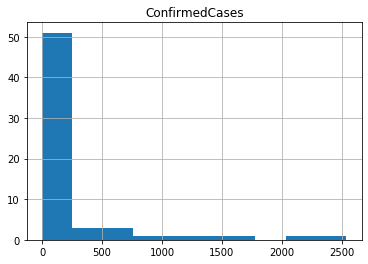

In [6]:
# Histogram of confirmed cases
train.hist('ConfirmedCases');

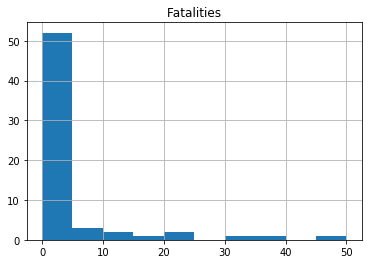

In [7]:
# Histogram of fatalities
train.hist('Fatalities');

In [8]:
# Add time features

train = train[['Id', 'Date', 'ConfirmedCases','Fatalities']]

train['Date'] = pd.to_datetime(train['Date'])
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.week
train['Day'] = train['Date'].dt.day
train['WeekDay'] = train['Date'].dt.dayofweek
train['YearDay'] = train['Date'].dt.dayofyear

train.head()

,Id,Date,ConfirmedCases,Fatalities,Month,Week,Day,WeekDay,YearDay
0,1,2020-01-22,0.0,0.0,1,4,22,2,22
1,2,2020-01-23,0.0,0.0,1,4,23,3,23
2,3,2020-01-24,0.0,0.0,1,4,24,4,24
3,4,2020-01-25,0.0,0.0,1,4,25,5,25
4,5,2020-01-26,0.0,0.0,1,4,26,6,26


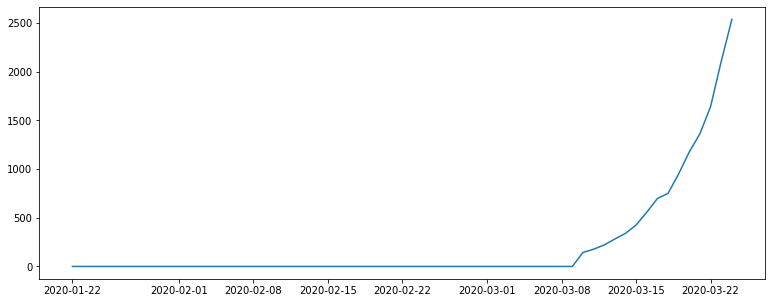

In [9]:
# Plot confirmed cases
plt.figure(figsize=(13,5))
plt.plot(train['Date'],train['ConfirmedCases'])

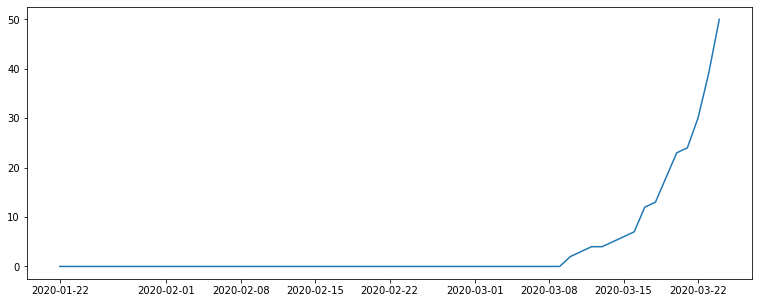

In [10]:
# Plot fatalities
plt.figure(figsize=(13,5))
plt.plot(train['Date'],train['Fatalities'])

## Feature Engineering

In [11]:
X = train.drop(['ConfirmedCases','Fatalities','Id'],axis=1)
y = train[['ConfirmedCases','Fatalities']]

In [12]:
## Month/day combination should be cyclic
# Map on to a circle
X['days_after_Jan1'] = X['Date']-pd.Timestamp(2020,1,1)
X['days_after_Jan1'] = X['days_after_Jan1'].apply(lambda x:x.days)
X['sin_day'] =  np.sin(2*np.pi*X.days_after_Jan1/365)
X['cos_day'] =  np.cos(2*np.pi*X.days_after_Jan1/365)
 # Day of week should be cyclic
X['sin_DayofWeek'] = np.sin((X.WeekDay)*(2*np.pi/7))
X['cos_DayofWeek'] = np.cos((X.WeekDay)*(2*np.pi/7))
X = X[['sin_day','cos_day','sin_DayofWeek','cos_DayofWeek']]

In [13]:
# Normalization
from sklearn.preprocessing import StandardScaler
scaled_features = X.copy()
scaler = StandardScaler().fit(scaled_features.values)
features = scaler.transform(scaled_features.values)
scaled_features.iloc[:,:] = features
X = scaled_features.copy()
X.head()

,sin_day,cos_day,sin_DayofWeek,cos_DayofWeek
0,-2.015092,1.425114,1.378756,-0.314692
1,-1.931947,1.399027,0.613604,-1.274162
2,-1.849370,1.371786,-0.613604,-1.274162
3,-1.767385,1.343400,-1.378756,-0.314692
4,-1.686016,1.313877,-1.105677,0.881748


## Build Models

In [14]:
# Baseline
# Linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

# Cross validation
from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

cv = TimeSeriesSplit()
score = []
for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training
    reg.fit(X_train, y_train)

    # For the metric, we need the predictions of the model
    y_pred = reg.predict(X_test)
    score.append(metrics.mean_squared_log_error(y_test, y_pred))

print("CV Error:",np.average(score))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19 20 21 22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25 26 27 28 29 30 31 32]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] TEST: [33 34 35 36 37 38 39 40 41 42]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] TEST: [43 44 45 46 47 48 49 50 51 52]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] TEST: [53 54 55 56 57 58 59 60 61 62]
CV Error: 2.0845611015087124


In [15]:
from sklearn.linear_model import RidgeCV
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

cv = TimeSeriesSplit()
score = []
for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training
    clf.fit(X_train, y_train)

    # For the metric, we need the predictions of the model
    y_pred = clf.predict(X_test)
    score.append(metrics.mean_squared_log_error(y_test, y_pred))

print("CV Error:",np.average(score))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19 20 21 22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25 26 27 28 29 30 31 32]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] TEST: [33 34 35 36 37 38 39 40 41 42]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] TEST: [43 44 45 46 47 48 49 50 51 52]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] TEST: [53 54 55 56 57 58 59 60 61 62]
CV Error: 2.087889821344701


In [16]:
# Random forest
# Evaluated by sqrt of mean squared log error
# Use CV

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

regr = RandomForestRegressor(random_state=0)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [17]:
# Random search of parameters, using 5 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = regr, param_distributions = random_grid,scoring="neg_mean_squared_log_error",n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)

In [18]:
# Cross validation
from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

cv = TimeSeriesSplit()
score = []
for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training
    rf_random.fit(X_train, y_train)

    # For the metric, we need the predictions of the model
    y_pred = rf_random.predict(X_test)
    score.append(metrics.mean_squared_log_error(y_test, y_pred))

print("CV Error:",np.average(score))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19 20 21 22]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25 26 27 28 29 30 31 32]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] TEST: [33 34 35 36 37 38 39 40 41 42]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] TEST: [43 44 45 46 47 48 49 50 51 52]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] TEST: [53 54 55 56 57 58 59 60 61 62]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


CV Error: 1.995692511616572


In [19]:
# Decision Tree

from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(random_state=0)

# Number of trees in random forest
min_impurity_decrease = [int(x) for x in np.linspace(start = 0, stop = 12, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'min_impurity_decrease': min_impurity_decrease,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [20]:
# Random search of parameters, using 5 fold cross validation, 
rf_dt = RandomizedSearchCV(estimator = regr, param_distributions = random_grid,scoring="neg_mean_squared_log_error",
                           n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)
cv = TimeSeriesSplit()
score = []
for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training
    rf_dt.fit(X_train, y_train)

    # For the metric, we need the predictions of the model
    y_pred = rf_dt.predict(X_test)
    score.append(metrics.mean_squared_log_error(y_test, y_pred))

print("CV Error:",np.average(score))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19 20 21 22]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25 26 27 28 29 30 31 32]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] TEST: [33 34 35 36 37 38 39 40 41 42]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] TEST: [43 44 45 46 47 48 49 50 51 52]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] TEST: [53 54 55 56 57 58 59 60 61 62]
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CV Error: 1.9576604900397805


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [21]:
# K-Neighbors

from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()

random_grid = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}


In [22]:
# Random search of parameters, using 5 fold cross validation, 
rf_knn = RandomizedSearchCV(estimator = model, param_distributions = random_grid,scoring="neg_mean_squared_log_error",
                           n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)
cv = TimeSeriesSplit()
score = []
for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training
    rf_knn.fit(X_train, y_train)

    # For the metric, we need the predictions of the model
    y_pred = rf_knn.predict(X_test)
    score.append(metrics.mean_squared_log_error(y_test, y_pred))

print("CV Error:",np.average(score))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19 20 21 22]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25 26 27 28 29 30 31 32]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] TEST: [33 34 35 36 37 38 39 40 41 42]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] TEST: [43 44 45 46 47 48 49 50 51 52]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] TEST: [53 54 55 56 57 58 59 60 61 62]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s


CV Error: 2.904695328474731


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


In [23]:
# Xgboost
import xgboost as xgb
xgbr = xgb.XGBRegressor(verbosity=0) 

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 5,6,8,10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [24]:
# Random search of parameters, using 5 fold cross validation for confirmed cases
boost_confirmed = RandomizedSearchCV(estimator = xgbr, param_distributions = random_grid,scoring="neg_mean_squared_log_error",
                           n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)
cv = TimeSeriesSplit()
score = []
for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training
    boost_confirmed.fit(X_train, y_train['ConfirmedCases'])

    # For the metric, we need the predictions of the model
    y_pred = boost_confirmed.predict(X_test)
    score.append(metrics.mean_squared_log_error(y_test['ConfirmedCases'], y_pred))

print("CV Error:",np.average(score))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19 20 21 22]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25 26 27 28 29 30 31 32]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] TEST: [33 34 35 36 37 38 39 40 41 42]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] TEST: [43 44 45 46 47 48 49 50 51 52]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] TEST: [53 54 55 56 57 58 59 60 61 62]
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CV Error: 3.2492683922975436


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [25]:
# Random search of parameters, using 5 fold cross validation for fatalities
boost_fat = RandomizedSearchCV(estimator = xgbr, param_distributions = random_grid,scoring="neg_mean_squared_log_error",
                           n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)
cv = TimeSeriesSplit()
score = []
for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training
    boost_fat.fit(X_train, y_train['Fatalities'])

    # For the metric, we need the predictions of the model
    y_pred = boost_fat.predict(X_test)
    score.append(metrics.mean_squared_log_error(y_test['Fatalities'], y_pred))

print("CV Error:",np.average(score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19 20 21 22]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25 26 27 28 29 30 31 32]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] TEST: [33 34 35 36 37 38 39 40 41 42]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] TEST: [43 44 45 46 47 48 49 50 51 52]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] TEST: [53 54 55 56 57 58 59 60 61 62]
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CV Error: 0.5822047876008447


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [26]:
np.mean([0.5822047876008447,3.2492683922975436])

1.9157365899491943

## Create Submission File

In [186]:
test['Date'] = pd.to_datetime(test['Date'])
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.week
test['Day'] = test['Date'].dt.day
test['WeekDay'] = test['Date'].dt.dayofweek
test['YearDay'] = test['Date'].dt.dayofyear
X = test[['Date','Month','Week','WeekDay','YearDay']]

In [187]:
## Month/day combination should be cyclic
# Map on to a circle
X.loc[:,'days_after_Jan1'] = X.loc[:,'Date']-pd.Timestamp(2020,1,1)
X.loc[:,'days_after_Jan1'] = X.loc[:,'days_after_Jan1'].apply(lambda x:x.days)
X.loc[:,'sin_day'] =  np.sin(2*np.pi*X.days_after_Jan1/365)
X.loc[:,'cos_day'] =  np.cos(2*np.pi*X.days_after_Jan1/365)
 # Day of week should be cyclic
X.loc[:,'sin_DayofWeek'] = np.sin((X.WeekDay)*(2*np.pi/7))
X.loc[:,'cos_DayofWeek'] = np.cos((X.WeekDay)*(2*np.pi/7))
X = X[['sin_day','cos_day','sin_DayofWeek','cos_DayofWeek']]

C:\Users\nacho\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\nacho\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [188]:
# Normalization
X.iloc[:,:] = scaler.transform(X.values)
X.head()

,sin_day,cos_day,sin_DayofWeek,cos_DayofWeek
0,1.021831,-1.062688,6.136043e-01,-1.274162
1,1.051571,-1.130681,-6.136043e-01,-1.274162
2,1.079859,-1.199077,-1.378756e+00,-0.314692
3,1.106687,-1.267857,-1.105677e+00,0.881748
4,1.132047,-1.337001,-9.968841e-18,1.414214


In [189]:
# Create submission
y_pred_fat = boost_fat.predict(X)
y_pred_conf = boost_confirmed.predict(X)

In [190]:
predictions = pd.DataFrame(y_pred_conf)
predictions['ForecastId'] = test['ForecastId']
predictions['Fatalities']=y_pred_fat
predictions = predictions.rename(columns={0: "ConfirmedCases", 1: "Fatalities"})
predictions.drop(labels=['ForecastId'], axis=1,inplace = True)
predictions.insert(0, 'ForecastId', test['ForecastId'])
predictions.tail()

,ForecastId,ConfirmedCases,Fatalities
38,39,339.998779,4.998659
39,40,339.998779,4.998659
40,41,281.999695,3.999790
41,42,220.582108,3.999790
42,43,177.418991,3.000217


### Create submission File

In [191]:
predictions.to_csv('submission.csv', index=False)